In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import sys 
import regtricks as rt 
import matplotlib.pyplot as plt

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf
from svb.main import run 
from svb_models_asl import AslRestModel 
from svb.data import VolumetricModel
from svb_models_asl import AslRestModel 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single PLD data, no PVE 

In [37]:
plds = [1.8]
repeats = 5
CBF = 60 
ATT = 1.3
bins = np.arange(10,70,2)

In [88]:
spc = rt.ImageSpace.create_axis_aligned([0,0,0], [5,5,5], [1,1,1])

data = np.zeros((*spc.size, repeats))
asl_model = AslRestModel(
        VolumetricModel(spc.make_nifti(data)), 
        plds=plds, casl=True, repeats=repeats)

tpts = asl_model.tpts()
with tf.Session() as sess:
    ones = np.ones([spc.size.prod(), 1], dtype=np.float32)
    sasl = sess.run(asl_model.evaluate([CBF * ones, ATT * ones], tpts))

sasl = sasl.reshape(*spc.size, tpts.shape[-1])
print(sasl.max())

35.723766


In [77]:
options = {
    "learning_rate" : 0.02,
    "batch_size" : repeats,
    "sample_size" : 5,
    "epochs" : 1500,
    "log_stream" : sys.stdout,
    "display_step": 500,  
    "prior_type": "N",
    
    "plds": plds, 
    "repeats": repeats, 
    "casl": True, 
    "attsd": 1e-6,
}

runtime, svb, training_history = run(
    spc.make_nifti(sasl), "aslrest",
    "vol_demo", 
    **options)

means = svb.evaluate(svb.model_means)
gm_cbf = means[0]
att = means[1]

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post29
INFO :  - Bolus duration: 1.8
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [3.6]
INFO :  - Post-labelling delays (for CASL instead of TIs): [1.8]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (125,), mean 1.3
INFO :  - Bolus arrival time: 1.3
INFO :  - Bolus arrival time prior std.dev.: 1e-06
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (125,), mean 0.01
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (125,), mean 0.9
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1 value: 1.1
INFO :  - WM parition coefficient. See --pc: 0.8
INFO :  - WM perfusion value to 

41.161465


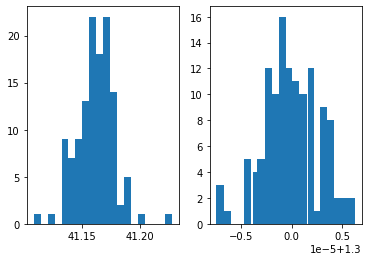

In [79]:
plt.subplot(1,2,1)
plt.hist(gm_cbf, 20)
plt.subplot(1,2,2)
plt.hist(att, 20)
print(gm_cbf.mean())

In [100]:
options = {
    "learning_rate" : 0.005,
    "batch_size" : repeats,
    "sample_size" : 5,
    "epochs" : 2000,
    "log_stream" : sys.stdout,
    "display_step": 5,  

    "param-spatial-priors": "NN",  
    "plds": plds, 
    "repeats": repeats, 
    "casl": True, 
    "attsd": 1e-6,
    
    "param_overrides" : {
        "ftiss" : {
            "post_mean": 65,
            "post_init": None,
        }
    }
#     "save"
}

runtime, svb, training_history = run(
    spc.make_nifti(sasl), "aslrest",
    "vol_demo", 
    **options)

means = svb.evaluate(svb.model_means)
gm_cbf = means[0]
att = means[1]

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post29
INFO :  - Bolus duration: 1.8
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [3.6]
INFO :  - Post-labelling delays (for CASL instead of TIs): [1.8]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (125,), mean 1.3
INFO :  - Bolus arrival time: 1.3
INFO :  - Bolus arrival time prior std.dev.: 1e-06
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (125,), mean 0.01
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (125,), mean 0.9
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1 value: 1.1
INFO :  - WM parition coefficient. See --pc: 0.8
INFO :  - WM perfusion value to 

63.38907 0.00011706546


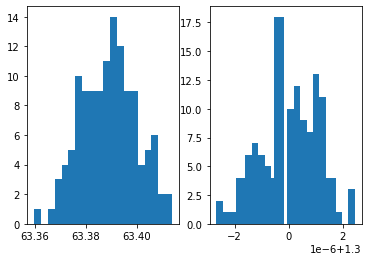

In [101]:
plt.subplot(1,2,1)
plt.hist(gm_cbf, 20)
plt.subplot(1,2,2)
plt.hist(att, 20)
print(gm_cbf.mean(), gm_cbf.var())